# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [ ]:
# The following code was modified after submitting my final project to include provided improvements from the feedback received
# after submitting my project.

In [1]:
# Imports here
import matplotlib.pyplot as plt
import seaborn as sb

import copy
import torch
import numpy as np
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([transforms.Resize(255),
                                transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),
                                                    (0.229, 0.224, 0.225))]),
    
    'valid': transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]),
    
    'test': transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])
    
}

# TODO: Load the datasets with ImageFolder
# applying transforms to data set images
image_datasets = {
    'train': datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train']),
    'valid': datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['valid']),
    'test': datasets.ImageFolder(data_dir + '/test', transform=data_transforms['test'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
# setting parameters for dataloader
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size = 32, shuffle=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size = 32, shuffle=True)
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
print(len(cat_to_name))
print(cat_to_name)

102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54'

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# Load and view pretrained VGG model
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
# Freeze pretrained model parameters 
for param in model.parameters(): # go through all parameters of VGG model and turn off gradient calculation
    param.requires_grad = False

In [19]:
# Build feedforward classifier
classifier = nn.Sequential(OrderedDict([
                          ('dropout', nn.Dropout(p=0.5)),
                          ('input', nn.Linear(25088, 4096)), # use 25088 to match the output of the input features
                                                             # found above in VGG model.
                          ('relu_1', nn.ReLU()),
                          ('hidden_layer_1', nn.Linear(4096, 4096)),
                          ('relu_2', nn.ReLU()),
                          ('hidden_layer_2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))])) # take Log of Softmax column-wise

model.classifier = classifier #this replaces the VGG classifier with the classifier defined  
                              #above. Notice output is 102 for all flower labels.

# Check for a GPU
if torch.cuda.is_available():
    model.to('cuda') # direct model to GPU
else:
    print('No GPU found. Please use a GPU to train your neural network.')

In [11]:
# setting parameters for custom built classifier
criterion = nn.NLLLoss() # use natural Log of output since Log of Softmax was used for output

optimizer = optim.Adam(model.parameters(), lr=0.001) # optimize all parameters in classifier

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1) # decrease learning rate by 0.1 every 4 epoch(s)

In [9]:
def train_model(state):
    correct = 0
    model_loss = 0.0
            
    if state == 'valid' or state == 'test':
        model.eval()
    else:
        scheduler.step()
        model.train()
    
    for images, labels in dataloaders[state]: # trainloader batch size is 64
        optimizer.zero_grad() # clear out all gradients with zero
        images, labels = images.to('cuda'), labels.to('cuda') # direct images, labels tensor to GPU

        if state == 'valid' or state == 'test':
            with torch.set_grad_enabled(False): # turn off gradient calculations during validation
                output = model(images) # calculate output by passing images through model
                _, predictions = torch.max(output, 1) # get indices of all max values from output tensor
                loss = criterion(output, labels) # determine loss as calculated by output and predicted value
        else:
            with torch.set_grad_enabled(True): # turn on gradient calculations during training               
                output = model(images) # calculate output by passing images through model
                _, predictions = torch.max(output, 1) # get indices of all max values from output tensor
                loss = criterion(output, labels) # determine loss as calculated by output and predicted value
                loss.backward() # using loss value go back through model and calculate all gradients for all parameters
                optimizer.step() # update all the weights using gradients found in previous step
                
        model_loss += loss.item() * images.size(0) # running total of loss calculation times batch size                           
        correct += (predictions == labels).sum().item() # count all predictions that match labels
        
    return (model_loss, correct)

In [10]:
# TODO: Build and train your network
epochs = 10
best_model = copy.deepcopy(model.state_dict()) # clone & save model state
max_accuracy = 0.0
print("Calculating...\n")

for epoch in range(epochs):

    for state in ['train', 'valid']:
       
        model_loss, correct = train_model(state)

        state_accuracy = float(correct) / len(image_datasets[state]) # calculate accuracy
        training_loss = model_loss / len(image_datasets[state]) # calculate loss

        print("{} state".format((state), len(image_datasets[state])))
        if state == 'valid' and state_accuracy > max_accuracy: # determine if validation images achieve greater accuracy
            max_accuracy = state_accuracy 
            best_model = copy.deepcopy(model.state_dict()) # clone validation model state if best
            
        print("Epoch: {}/{} ".format(epoch+1, epochs),
              "Loss: {:.3f} ".format(training_loss),
              "Accuracy: {:.3f}".format(state_accuracy))   # show results per epoch
    print()
    
model.load_state_dict(best_model) # load best model
print("Total images used in training:", len(image_datasets['train']))
print("Total images used in validation:", len(image_datasets['valid']))

Calculating...

train state
Epoch: 1/10  Loss: 3.154  Accuracy: 0.283
valid state
Epoch: 1/10  Loss: 1.366  Accuracy: 0.598

train state
Epoch: 2/10  Loss: 1.620  Accuracy: 0.565
valid state
Epoch: 2/10  Loss: 0.978  Accuracy: 0.737

train state
Epoch: 3/10  Loss: 1.298  Accuracy: 0.650
valid state
Epoch: 3/10  Loss: 0.809  Accuracy: 0.774

train state
Epoch: 4/10  Loss: 0.988  Accuracy: 0.725
valid state
Epoch: 4/10  Loss: 0.585  Accuracy: 0.829

train state
Epoch: 5/10  Loss: 0.908  Accuracy: 0.751
valid state
Epoch: 5/10  Loss: 0.548  Accuracy: 0.845

train state
Epoch: 6/10  Loss: 0.837  Accuracy: 0.764
valid state
Epoch: 6/10  Loss: 0.531  Accuracy: 0.857

train state
Epoch: 7/10  Loss: 0.815  Accuracy: 0.766
valid state
Epoch: 7/10  Loss: 0.504  Accuracy: 0.856

train state
Epoch: 8/10  Loss: 0.786  Accuracy: 0.779
valid state
Epoch: 8/10  Loss: 0.497  Accuracy: 0.855

train state
Epoch: 9/10  Loss: 0.790  Accuracy: 0.768
valid state
Epoch: 9/10  Loss: 0.492  Accuracy: 0.856

tra

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx # add to model the class to index dictionary 

# Instructor notes
# Please do not save the complete model in the checkpoint. It is a bad practice to do so
# and generates a pretty huge checkpoint file. Instead, you should consider saving the name of the model
# in the checkpoint and use that name to recreate the model.

# checkpoint below was changed so the entire model is not saved
checkpoint = { 'arch': 'vgg16', 
               'class_to_idx': model.class_to_idx,
               'state_dict': model.state_dict(),
               'hidden_units': 4096
             }

torch.save(checkpoint, 'checkpoint.pth') # save checkpoint to file 'checkpoint.pth'

In [12]:
print(model.class_to_idx)

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [6]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    units = checkpoint['hidden_units']

    if checkpoint['arch'] == 'vgg16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters(): # go through all parameters of VGG model and turn off gradient calculation
            param.requires_grad = False
            
        classifier = nn.Sequential(OrderedDict([
                      ('dropout', nn.Dropout(p=0.5)),
                      ('input', nn.Linear(25088, units)), # use 25088 to match the output of the input features
                                                         # found above in VGG model.
                      ('relu_1', nn.ReLU()),
                      ('hidden_layer_1', nn.Linear(units, units)),
                      ('relu_2', nn.ReLU()),
                      ('hidden_layer_2', nn.Linear(units, 102)), #Notice output is 102 for all flower labels.
                      ('output', nn.LogSoftmax(dim=1))])) # take Log of Softmax column-wise
    else:
        raise SystemExit("Sorry base architecture note recognized.")
        
    model.classifier = classifier
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [7]:
model = load_checkpoint('checkpoint.pth')
model.to('cuda') # must remember to send model to GPU as it was done during the creation or else an error will occur
                 # with some tensors using CPU and others using GPU

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [12]:
# TODO: Do validation on the test set
state = 'test'
model_loss, correct = train_model(state) # run test images through model, return results
state_accuracy = float(correct) / len(image_datasets[state]) # calculate accuracy
training_loss = model_loss / len(image_datasets[state]) # calculate loss

print(" {} images {}\n".format((state), len(image_datasets[state])), 
      "Loss: {:.3f} ".format(training_loss),
      "Accuracy: {:.3f}".format(state_accuracy)) # show results

 test images 819
 Loss: 0.570  Accuracy: 0.844


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [13]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model   
    pil_image = Image.open(image)
    
    # First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the
    # thumbnail or resize methods.
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((pil_image.size[0], 256)) # double parenthesis because module uses size (width, height) with 
    else:                                             # optional parameters but here none are given so we close with () around
        pil_image.thumbnail((256, pil_image.size[1])) # arguments
        
    # Crop out the center 224x224 portion of the image.
    bottom_margin = (pil_image.height - 224)/2
    top_margin = bottom_margin + 224
    left_margin = (pil_image.width - 224)/2
    right_margin = left_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    
    # Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to 
    # convert the values. It's easiest with a Numpy array, which you can get from a PIL image 
    # like so np_image = np.array(pil_image).
    np_image = np.array(pil_image)/255
    
    # As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] 
    # and for the standard deviations [0.229, 0.224, 0.225]. You'll want to subtract the means from each color channel,
    # then divide by the standard deviation. 
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    np_image = (np_image - mean)/std
    
    # And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL
    # image and Numpy array. You can reorder dimensions using ndarray.transpose. The color channel needs to be first and 
    # retain the order of the other two dimensions.
    np_image = np_image.transpose((2,0,1))
    print(np_image.shape)
    
    # The following Pytorch transformation could have been used but the challenge was to use the PIL image in a numpy array
    # to achieve the same results.
    #
    #process_image = transforms.Compose([transforms.Resize(256),
    #                                    transforms.CenterCrop(224),
    #                                    transforms.ToTensor(),
    #                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                                                          std=[0.229, 0.224, 0.225])])
    #tensor_image = process_image(pil_image)
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    try: 
        image = image.numpy().transpose((1,2,0)) # if image is passed into function as tensor transpose tensor
    except AttributeError:
        image = image.transpose((1,2,0)) # if not tensor then image must be numpy array transpose array
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

(3, 224, 224)


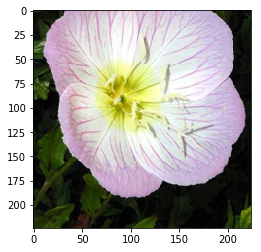

In [15]:
image = process_image('flowers/test/1/image_06743.jpg')
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    import os, random

    count = 0
    random_file = random.randint(1, len(image_datasets['test'])) # generate a random number from 1 to total number of test images
    model.eval()
    for root, dirs, files in os.walk(image_path): # walk through all folders and files in the flowers root directory
        for name in files:
            count += 1
            if count == random_file: # stop walking through files (images) when random number equals counter
                image = os.path.join(root, name)
                flower_class = root.split('\\')[1]
                image = process_image(image) # process image
                tensor_image = torch.from_numpy(image).type(torch.FloatTensor).cuda() # convert from array to tensor
                with torch.set_grad_enabled(False):
                    output = model(tensor_image.unsqueeze(0).float()) # calculate output by passing images through model
                    probs = nn.functional.softmax(output.data, dim=1) # convert output to probabilities
                    probabilities = probs.topk(topk) # get indices of all k highest probabilities from output tensor
    
    return probabilities, tensor_image.cpu(), flower_class

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

(3, 224, 224)


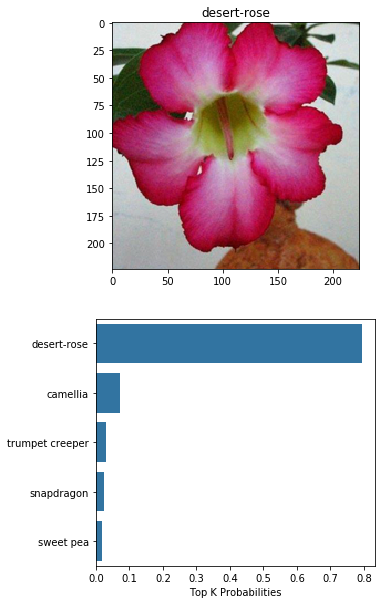

In [17]:
# TODO: Display an image along with the top 5 classes

probabilities, tensor_image, flower_class = predict(test_dir, model) # run predict function and return results
probs = probabilities[0].cpu().numpy().flatten() # send probability value tensor to cpu to convert to 1D numpy array (flatten)
indicies = probabilities[1].cpu().numpy().flatten() # send probability index tensor to cpu to convert to 1D numpy array (flatten)

class_no_list = []
class_names = []

for x in range(len(indicies)):
    for class_no, idx in model.class_to_idx.items():
        if idx == indicies[x]:
            class_no_list.append(class_no) # build list of class numbers based on indicies returned
            class_names.append(cat_to_name[class_no_list[x]]) # build list of class names

plt.figure(figsize = (5,10))
ax = plt.subplot(2,1,1)
imshow(tensor_image, ax, title=cat_to_name[flower_class]); # show flower selected by predict function

plt.subplot(2,1,2)
plt.xlabel('Top K Probabilities')
sb.barplot (x=probs, y=class_names, color=sb.color_palette()[0]); # plot results of top 5 predicted flowers and probabilities
plt.show()